## From Kaplan 

In [1]:
import networkx as nx
import underworld as uw
import math
from underworld import function as fn
import glucifer
#import matplotlib.pyplot as pyplot
import time
import numpy as np
import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import slippy2 as sp
import operator
import pint

from slippy2 import boundary_layer2d
from slippy2 import material_graph


from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [2]:
############
#Model name.  
############
Model = "T"
ModNum = 0

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])

In [3]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early 

In [4]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False
        

results/T/0/Base/checkpoint/ is empty


In [33]:
###########
#Use pint to setup any unitconversions we'll need
###########


u = pint.UnitRegistry()
cmpery = u.cm/u.year
mpermy = u.m/u.megayear


10.*cmpery.to(mpermy)

<Quantity(100000.0, 'meter / megayear')>

In [6]:
###########
#Physical parameters
###########

#dimensional parameter dictionary
dp = edict({'LS':660.*1e3,
           'rho':3300,
           'g':9.81, 
           'eta0':1e20,
           'k':10**-6,
           'a':3e-5, 
           'deltaT':1400,
           'TS':273.,
           'TB':1673.,
           'cohesion':5e6,
           #'cohesion':128e6,
           'fc':0.03,
           'E':1e5, 
           'StALS': 27.*1e3, 
           'G':8e10, 
           'plate_vel':10})

#scale_factors

sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
           'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) ,
           'vel':dp.LS/dp.k })

#dimensionless parameters

ndp = edict({'RA':(dp.g*dp.rho*dp.a*dp.deltaT *(dp.LS)**3)/(dp.k*dp.eta0),
           'cohesion':dp.cohesion*sf.stress,
            'fcd':dp.fc*sf.lith_grad,
            'TS':0.,
            'TB':1.,
            'low_visc':1e-4,
            'StAeta0':0.01,
            'up_visc':1e5,
            'H':0.,
            'G':dp.G*sf.stress,
            'plate_vel':sf.vel*dp.plate_vel*(cmpery.to(u.m/u.second)).magnitude})

In [7]:
#origRA = ndp.RA 
#ndp.RA  = 5e8
#ndp.cohesion = ndp.cohesion*(ndp.RA/origRA)
#ndp.plate_vel 
#ndp.RA = 4e7

In [8]:
ETAREF = dp.rho*dp.g*dp.a*dp.deltaT*((dp.LS)**3)/(ndp.RA*dp.k) #equivalent dimensional reference viscosity
#RC = (3300.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
RCA = (1650.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
COMP_RA_FACT_AIR = RCA/ndp.RA
#RCC = (100.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for crust
#COMP_RA_FACT_CRUST = RCC/ndp.RA
#RCE = -1*(200.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for eclogite 
#COMP_RA_FACT_ECL = RCE/ndp.RA
ndp["StA_RA"] = ndp.RA*COMP_RA_FACT_AIR

In [9]:
#A few parameters defining lengths scales, affects materal transistions etc.
MANTLETOCRUST = (20.*1e3)/dp.LS #Crust depth
CRUSTTOMANTLE = (900.*1e3)/dp.LS 
LITHTOMANTLE = (900.*1e3)/dp.LS 
MANTLETOLITH = (200.*1e3)/dp.LS 
TOPOHEIGHT = (0.*1e3)/dp.LS  #rock-air topography limits
CRUSTTOECL  = (100.*1e3)/dp.LS
AVGTEMP = ndp.TB #Used to define lithosphere

In [10]:
LITHTOMANTLE 

1.3636363636363635

In [11]:
###########
#Boundary layer / slab paramaters
###########

modelage  = 75 
subzone = -500.e3/dp.LS
mor = (1500e3/dp.LS) - (200e3/dp.LS)
vel =  dp.plate_vel*cmpery.to(mpermy).magnitude #The boundary_later2d function wants m/my
agelimit = 70.
thermallimit = 0.8

#Slab perturbation paramaters
Roc = 450.
Crust = 35.
theta = 89.

In [12]:
###########
#Model setup parameters
###########

stickyAir = False

MINX = -(1500/670.)
MINY = 0.
MAXX = 1500/670.

#MAXY = 1.035
MAXY = 1.

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    
dim = 2          # number of spatial dimensions


#MESH STUFF

RES = 64


Xres = int(RES*4)


if stickyAir:
    Yres = RES
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = RES
    MAXY = 1.


periodic = [False, False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"

refineMesh = True

#System/Solver stuff

PIC_integration=True
ppc = 25

In [13]:
###########
#Model Runtime parameters
###########

swarm_update = 5
swarm_repop = 5
files_output = 1e6
gldbs_output = 5
images_output = 1e6
checkpoint_every = 25
metric_output = 25
sticky_air_temp = 10

comm.Barrier() #Barrier here so not procs run the check in the next cell too early 

assert metric_output <= checkpoint_every, 'Checkpointing should run less or as ofen as metric output'
#assert (metric_output >= swarm_update), 'Swarm update is needed before checkpointing'
#assert metric_output >= sticky_air_temp, 'Sticky air temp should be updated more frequently that metrics'

In [14]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = elementType,
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX,MINY), 
                                 maxCoord=(MAXX,MAXY), periodic=periodic)



velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [15]:
# Initialise data.. Note that we are also setting boundary conditions here
#velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
temperatureDotField.data[:] = 0.

In [25]:
lith= boundary_layer2d.LithosphereTemps(mesh, temperatureField, dp.LS, MINX, mor, tint=ndp.TB, tsurf=ndp.TS, vel= 1e4, diffs = 1e-6)


In [26]:
vel

100000.0

In [27]:
coords = [(MINX, 1.), (subzone, 1.), (MINX, 0.)]
Tri = fn.shape.Polygon(np.array(coords))

In [28]:
for index, coord in enumerate(mesh.data):
    xloc = coord[0]
    agema = lith.agefunc(xloc)
    if coord[1] >= 1.:
            temperatureField.data[index] = lith.tsurf
    else:
        zloc = ((1.- coord[1])* dp.LS) # dimensional depth kms
        t = lith.tempfunc(agema, zloc)
        temperatureField.data[index] = t 
    if coord[1] <= 1. and coord[0] > mor: #Get rid of lithosphere to the right of the ridge
        temperatureField.data[index] = lith.tint
    if Tri.evaluate(tuple(coord)):
        temperatureField.data[index] = lith.tint


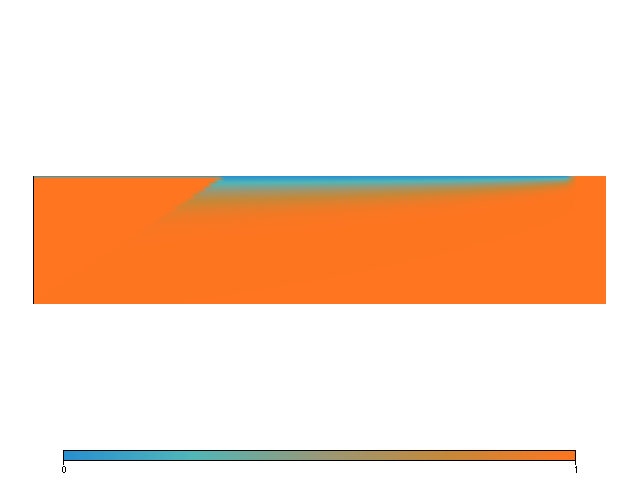

In [29]:
figTemp = glucifer.Figure()
figTemp.append( glucifer.objects.Surface(mesh, temperatureField))

#figTemp.save_database('test.gldb')
figTemp.show()

In [20]:
# send boundary condition information to underworld
IWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
JWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
TWalls = mesh.specialSets["MaxJ_VertexSet"]
BWalls = mesh.specialSets["MinJ_VertexSet"]

In [21]:
#Get indexSet for the p

Fixed = mesh.specialSets["Empty"]
for index in list(TWalls.data):
    if (mesh.data[int(index)][0] > subzone) and (mesh.data[int(index)][0] < mor):
        Fixed.add(int(index))
        #velocityField.data[index] = [-1.*ndp.plate_vel, 0.]
        


In [22]:
#Fixed.data.shape, TWalls.data.shape

In [23]:
#Set Dirichlet Temp conditions

for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = lith.tint
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = lith.tsurf


# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              indexSetsPerDof=(IWalls, JWalls) )

# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(JWalls,) )

# Particles

In [145]:
###########
#Material Swarm and variables
###########

gSwarm = uw.swarm.Swarm(mesh=mesh)
materialVariable = gSwarm.add_variable( dataType="int", count=1 )

In [146]:
mantleIndex = 0
lithosphereIndex = 1
eclIndex = 2
crustIndex = 3
airIndex = 4
tempIndex = 5




if checkpointLoad:
    checkpointLoadDir = natsort.natsorted(checkdirs)[-1]
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    # Create the layout object
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=ppc)
    # Now use it to populate.
    gSwarm.populate_using_layout( layout=layout )

    # Lets initialise the 'materialVariable' data to represent different materials
    # Set the material to heavy everywhere via the numpy array
    materialVariable.data[:] = mantleIndex
    
    
    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < 0:
                 materialVariable.data[particleID] = airIndex
        elif (1. - gSwarm.particleCoordinates.data[particleID][1]) < MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex


# Material Graphs

In [147]:
from networkx import DiGraph
import uuid


In [148]:
coordinate = fn.input()
depthFn = 1. - coordinate[1]

In [149]:
##############
#Important: This is a quick fix for a bug that arises in parallel runs
##############
material_list = [0,1,2,3]


In [150]:
#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

materialVariable.data[:] = 0

#######Graph object
#DG = nx.DiGraph(field="Depth")
DG = material_graph.MatGraph()

#Important: First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)


#######Edges
#anything to air


#Anything to mantle
#DG.add_transition((3,0), depthFn, operator.gt, CRUSTTOMANTLE)
DG.add_transition((1,0), depthFn, operator.gt, 0.5 )
#DG.add_transition((2,0), depthFn, operator.gt, CRUSTTOMANTLE)



#Anything to crust
#DG.add_transition((0,3), depthFn, operator.lt, MANTLETOCRUST)
DG.add_transition((1,3), depthFn, operator.lt, MANTLETOCRUST)
#DG.add_transition((4,3), depthFn, operator.lt, TOPOHEIGHT)

#Anything to lithsphere
DG.add_transition((0,1), depthFn, operator.lt, MANTLETOLITH)
DG.add_transition((0,1), temperatureField, operator.lt, 0.75*AVGTEMP)








#crust to eclogite
#DG.add_edges_from([(3,2)])
#DG[3][2]['depthcondition'] =CRUSTTOECL
#DG.add_transition((3,2), depthFn, operator.gt, CRUSTTOECL)

In [151]:
#%matplotlib inline
#nx.draw(DG,pos=nx.spring_layout(DG), with_label=True, cmap='jet')

In [152]:
DG.build_condition_list(materialVariable)

In [153]:
for i in range(2): #Need to go through twice first time through
    materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)


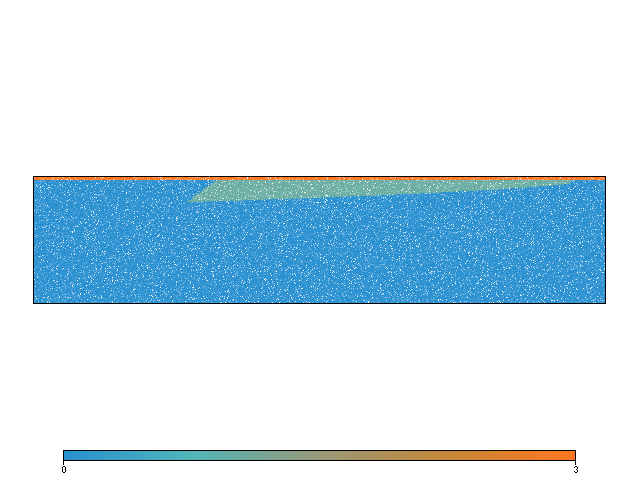

In [154]:
figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(gSwarm,materialVariable))
#figMat.append( glucifer.objects.Mesh(mesh))
#figMat.save_database('test.gldb')
figMat.show()

In [155]:
np.unique(materialVariable.data[:])

array([0, 1, 3], dtype=int32)

## Rheology

In [156]:
# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))




In [157]:
temperatureField.data.max()

1.0

In [158]:
arhennius = fn.misc.min(ndp.up_visc, fn.math.exp(-1*math.log(dp.E) + (math.log(dp.E) / (temperatureField + 1e-8))))



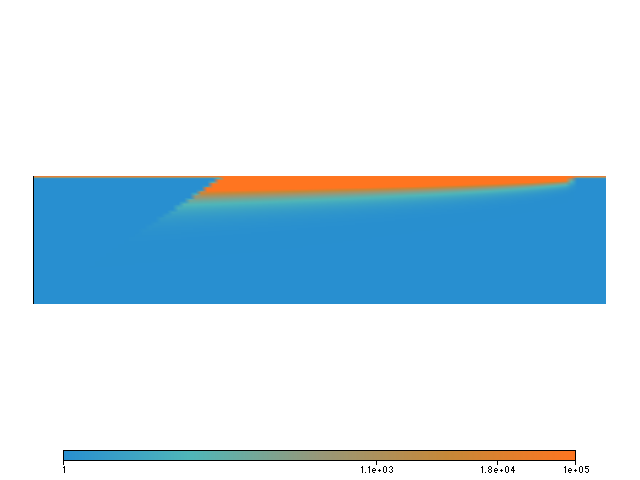

In [159]:
figVisc = glucifer.Figure()
figVisc.append( glucifer.objects.Surface(mesh, arhennius, logScale=True))
#figVisc.append(glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.0002))
figVisc.show()

In [160]:
ndp.fcd/ndp.cohesion

5.0076984375

In [161]:
#Psuedo-plastic 
ys =  ndp.cohesion + (depthFn*ndp.fcd)
#ys =  ndp.fc*lithopressuregrad*(30e3/dp.LS) # this is the byerlee strength at 30 km
yss = fn.misc.max(ndp.cohesion, ys)
plasticvisc = yss*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
plastic = fn.misc.max(ndp.low_visc,plasticvisc)
#combine these
mantleviscosityFn = fn.misc.min(arhennius, plastic)

############
#crust
############



ysc = (ndp.cohesion/10.) + (depthFn*(ndp.fcd/100.))
#ysc = ys/100.
ycs = fn.misc.max((ndp.cohesion/100.), ysc)
crustplasticvisc = ycs*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
crustplastic = fn.misc.max(ndp.low_visc,crustplasticvisc) 
crustviscosityFn = fn.misc.min(arhennius, crustplastic)

In [162]:
ndp.up_visc

100000.0

In [163]:
# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StAeta0, 
                                    lithosphereIndex:mantleviscosityFn, 
                                    crustIndex:mantleviscosityFn,
                                    mantleIndex:mantleviscosityFn, 
                                    eclIndex:mantleviscosityFn,
                                    tempIndex:mantleviscosityFn} )

densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StA_RA, 
                                    lithosphereIndex:ndp.RA*temperatureField, 
                                    crustIndex:ndp.RA*temperatureField, 
                                    mantleIndex:ndp.RA*temperatureField, 
                                    eclIndex:ndp.RA*temperatureField,
                                    tempIndex:ndp.RA*temperatureField, } )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )

buoyancyFn = gravity*densityMapFn
#buoyancyFn = [0.,0.]

## Build Stokes system

In [164]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               #swarm         = gSwarm, 
                               conditions    = [freeslipBC,],
                               fn_viscosity   = arhennius, 
                               fn_bodyforce   = buoyancyFn,
                               swarm=gSwarm)

In [165]:
#We do one solve with linear viscosity to get the initial strain rate invariant. 
#This solve step also calculates a 'guess' of the the velocity field based on the linear system, 
#which is used later in the non-linear solver.

solver = uw.systems.Solver(stokesPIC)
# If not doing a restart, do a solve on the non-plastic system
if not checkpointLoad:
    solver.solve()

In [166]:
#Switch particle escape on, this will also trigger the inflow population control 
gSwarm.particleEscape = True

In [167]:
####################
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = viscosityMapFn
###################

#Set more advanced solver option
solver.options.main.Q22_pc_type='gkgdiag'
#solver.options.A11.ksp_rtol=1e-2
#solver.options.scr.ksp_rtol=1e-3
#solver.options.A11.ksp_type="cg"
solver.options.scr.use_previous_guess = True
#solver.options.scr.ksp_set_min_it_converge = 1
#solver.options.main.penalty=10.0

#solver.options.mg.levels = 3
#solver.options.main.remove_constant_pressure_null_space=True
#solver.options.main.penalty = 1e2

solver.options.A11.ksp_rtol=1e-4
solver.options.scr.ksp_rtol=1e-4

solver.options.A11.ksp_monitor=''
solver.options.A11.ksp_converged_reason=''

In [168]:
solver.solve(nonLinearIterate=True)

In [169]:
velocityField.data[TWalls.data][:,0]


array([     0.        ,    344.25804146,    728.11304454,   1086.3245488 ,
         1419.3599568 ,   1760.0166045 ,   2192.72960778,   2612.91689949,
         2998.15100727,   3313.18899049,   3628.91989029,   3983.09790057,
         4416.86433965,   4804.61728371,   5172.62169924,   5560.42293017,
         6003.20439071,   6443.67134134,   6864.2912437 ,   7300.81793183,
         7763.34068157,   8272.14346551,   8754.82539008,   9223.36391373,
         9745.14653035,  10221.08071718,  10693.69532372,  11153.05615773,
        11671.6158689 ,  12240.22068665,  12825.2325833 ,  13344.4734321 ,
        13826.45780547,  14326.99454081,  14942.6439975 ,  15563.89593152,
        16158.08114873,  16719.75560914,  17384.02287245,  18104.94638781,
        18755.93844641,  19401.1945449 ,  20033.41941833,  20696.7499435 ,
        21370.61097971,  22078.98041728,  22659.01838952,  23151.57559788,
        23626.41593529,  24108.96393211,  24541.10716749,  24920.07470807,
        25193.17291112,  


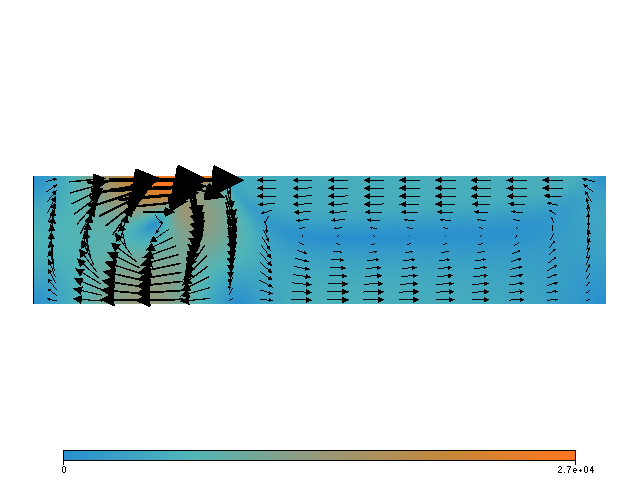

In [172]:

fig2 = glucifer.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig2.append( glucifer.objects.Surface(mesh, velmagfield) )
fig2.append( glucifer.objects.VectorArrows(mesh, velocityField,scaling=0.00003 ))
fig2.show()

In [171]:
velocityField.data[:,0].max()

26893.047462410603

In [110]:
#Create advdiff system



#advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
#                                         phiDotField    = temperatureDotField, 
#                                         velocityField  = velocityField, 
#                                         fn_diffusivity = 1.0,
#                                         fn_sourceTerm = 0.,
#                                         conditions     = [tempBC,] )


advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = ndp.H,
                                         fn_diffusivity = 1.0, 
                                         conditions     = [dirichTempBC,] )



advector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

In [111]:
pics = uw.swarm.PICIntegrationSwarm(gSwarm)

## Figures / gldbs etc

In [112]:
viscVariable = gSwarm.add_variable( dataType="float", count=1 )
viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)

In [113]:
#Pack some stuff into a database as well
figDb = glucifer.Figure()
#figDb.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
#figDb.append( glucifer.objects.Mesh(mesh))
#figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, arrowHead=0.2, scaling=0.01))
figDb.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Surface(mesh, temperatureField))

In [114]:
step = 0
realtime = 0.
timevals = [0.]

In [115]:
# initialise timer for computation
startMain = time.clock()
# Perform steps#
#while realtime < 0.2:
while step < 5:
    #Enter non-linear loop
    print step
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()/5.
    if step == 0:
        dt = 0.
    #start = time.clock()
    advDiff.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advDiff time is: " + str(machine_time))
    # Advect swarm using this timestep size
    #start = time.clock()
    advector.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advector time is: " + str(machine_time))
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0):
        #Rebuild any necessary swarm variables
        viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
        #Write gldbs
        fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        figDb.show()
        figDb.save_database(fullpath)
    ################
    #Also repopulate entire swarm periodically
    ################
    if step % swarm_repop == 0:
        pics.repopulate()
    print(temperatureField.data.max())
    
    ################
    #Particle update
    ###############
    if step % swarm_update == 0:
        for i in range(2): #Need to go through twice first time through
            materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

0
1.0
1
1.00467523724
2
1.00867431624
3
1.01231672311
4
1.01554694596



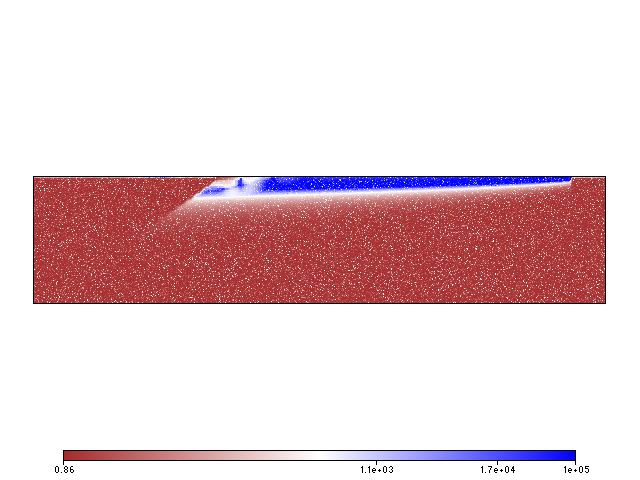

In [116]:
#Pack some stuff into a database as well
figVisc = glucifer.Figure()
figVisc.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True, colours='brown white blue'))
figVisc.show()

In [117]:
temperatureField.data.max()

1.0155469459567803


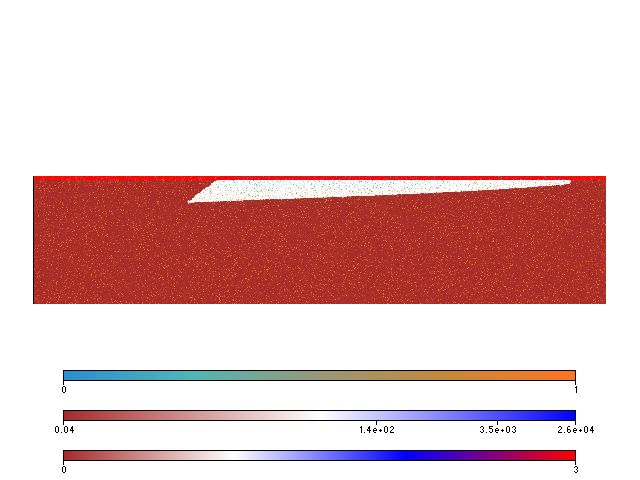

In [118]:
figDb.show()